# Visualizing with slideflow

In [16]:
import slideflow as sf

# Create the WSI object with the slide and Grayson's ROI CSV
#wsi_grayson represents instance of sfs WSI class, which is whole slide image along with the ROI annotations. 
# printing object tells you each ROI, it's coordinates, and label. Can also access class methods to get thumbnails etc. 
wsi_grayson = sf.WSI(
    path="/home/joeychan/labshare/SLIDES/PDCD10/TAM_then_4NQO/AF102F.svs",
    tile_px=256,
    tile_um=128,
    rois="/home/joeychan/labshare/PROJECTS/PDCD10/rois/grayson/AF102F.csv"
)

wsi_anna = sf.WSI(
    path="/home/joeychan/labshare/SLIDES/PDCD10/TAM_then_4NQO/AF102F.svs",
    tile_px=256,
    tile_um=128,
    rois="/home/joeychan/labshare/PROJECTS/PDCD10/rois/anna/AF102F.csv"
)


In [10]:
print(wsi_grayson.rois)
roi0 = wsi_grayson.rois[0]
print("ROI label:", roi0.label)


[<ROI (coords=137 label=Mild)>, <ROI (coords=107 label=Mild)>, <ROI (coords=1118 label=Benign)>, <ROI (coords=853 label=Benign)>, <ROI (coords=816 label=Benign)>, <ROI (coords=524 label=Benign)>, <ROI (coords=228 label=Benign)>, <ROI (coords=94 label=Benign)>, <ROI (coords=33 label=Benign)>]
ROI label: Mild


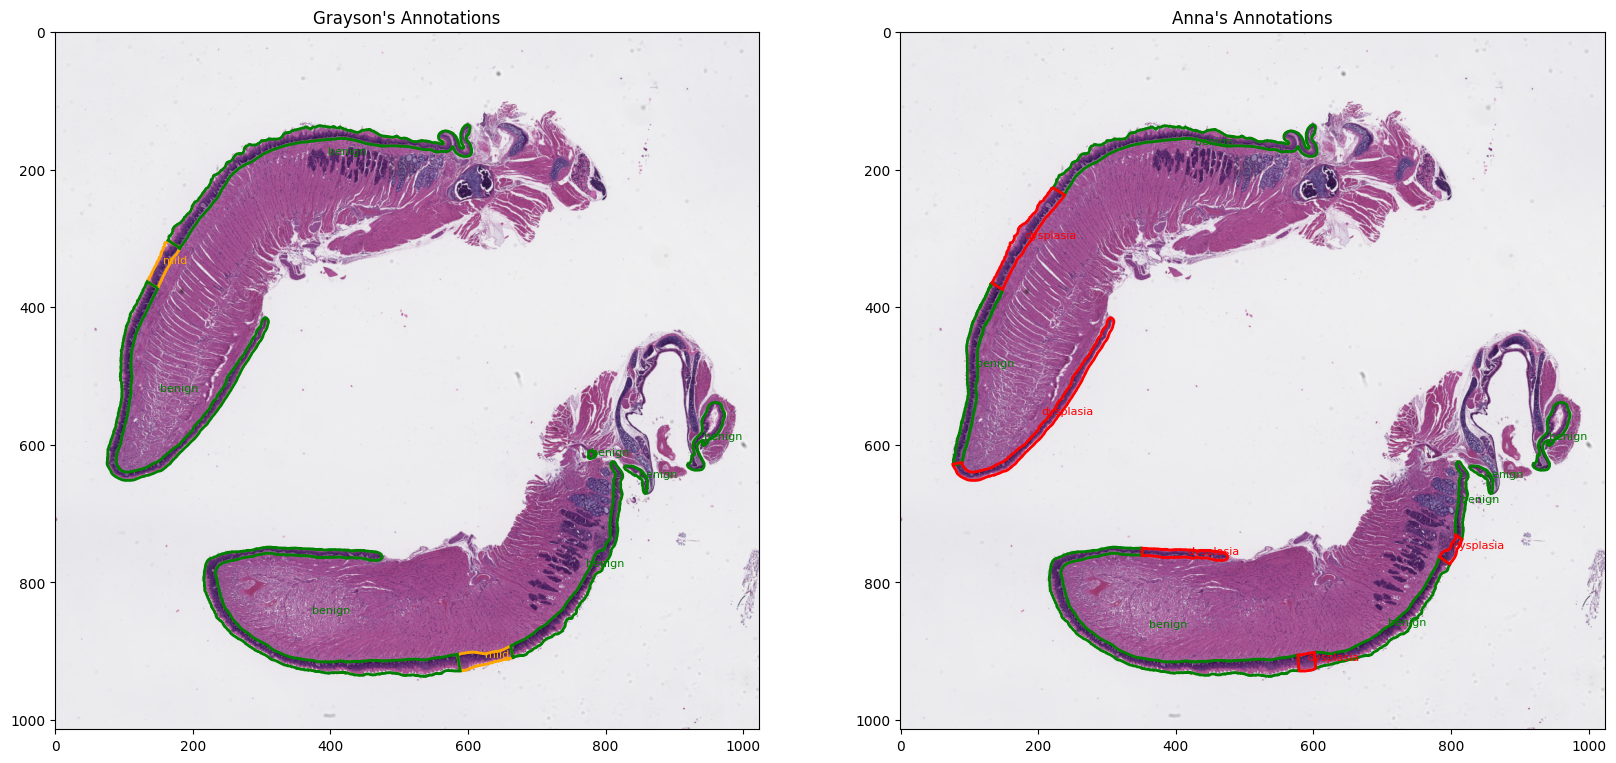

In [18]:
import slideflow as sf
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon as MplPolygon


# Generate thumbnails without ROI overlays
thumb_grayson = wsi_grayson.thumb(width=1024, rois=False)
thumb_anna = wsi_anna.thumb(width=1024, rois=False)

# Calculate scaling factor (assuming both slides have the same original dimensions)
orig_width, _ = wsi_grayson.dimensions
scale = thumb_grayson.width / orig_width

# Define a simple color mapping
color_map = {
    'dysplasia': 'red',
    'mild': 'orange',
    'moderate': 'yellow',
    'severe': 'purple'
}

def overlay_rois(ax, wsi_obj):
    # Loop through each ROI and overlay a polygon
    for roi in wsi_obj.rois:
        poly_coords = np.array(roi.poly.exterior.coords) * scale
        label = roi.label.lower() if roi.label else 'unknown'
        color = color_map.get(label, 'green')
        patch = MplPolygon(poly_coords, closed=True, edgecolor=color, fill=False, linewidth=2)
        ax.add_patch(patch)
        centroid = poly_coords.mean(axis=0)
        ax.text(centroid[0], centroid[1], label, fontsize=8, color=color)

# Create side-by-side plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

# Grayson's overlay
ax1.imshow(thumb_grayson)
overlay_rois(ax1, wsi_grayson)
ax1.set_title("Grayson's Annotations")

# Anna's overlay
ax2.imshow(thumb_anna)
overlay_rois(ax2, wsi_anna)
ax2.set_title("Anna's Annotations")

plt.show()


# Loading Data for Centerline Processing

In [2]:
#alternative method for loading the data
import pandas as pd
from shapely.geometry import Polygon
import matplotlib.pyplot as plt


# Load the CSV file
csv_path = "/home/joeychan/labshare/PROJECTS/PDCD10/rois/anna/AF110F.csv"
df = pd.read_csv(csv_path)

# Group points by ROI name
roi_polygons = {}
#note that groupby is grouping by the roi_name column
#note that group is just a subset of the dataframe corresponding to the roi_name
for roi_name, group in df.groupby("roi_name"):
    #taking the two series of x and y coordinates and zipping them together. Zip needs two interables and makes tuples
    points = list(zip(group["x_base"], group["y_base"]))  # Convert to (x, y) coordinates
    #adding to the dictionary
    roi_polygons[roi_name] = Polygon(points)  # Create Shapely Polygon

#pritning dictionary here
for roi, poly in roi_polygons.items():
    print(f"ROI {roi}: Area = {poly.area}, Length = {poly.length}")


ROI ROI_0: Area = 43997907.5, Length = 135854.52414235394
ROI ROI_1: Area = 26697910.0, Length = 90225.32576931092
ROI ROI_2: Area = 17543701.5, Length = 51532.14777417329


# Visualizing Voroni Graphs

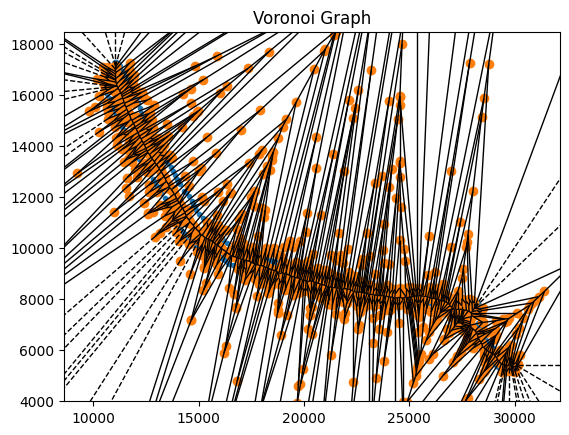

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, LineString, MultiLineString, Point
from shapely.ops import unary_union
from scipy.spatial import Voronoi, voronoi_plot_2d

# Select an example ROI polygon
roi_polygon = roi_polygons["ROI_2"]  # Replace with different ROI if needed

# Extract boundary points from the polygon
boundary_coords = np.array(roi_polygon.exterior.coords)

# Compute Voronoi diagram from boundary points
vor = Voronoi(boundary_coords)
fig = voronoi_plot_2d(vor)
plt.title("Voronoi Graph")
plt.show()

#get the vertices that define the regions
vor_vertices = vor.vertices


# Graph based with additional changes

Tried percetile based trimming and it works really well! Before ends of the graph based method were not representative of the centerline. Trimming seems to be a simpler solution rather than filtering based on width, angle, etc. 10% seems to be a good threshold. 

Note: can take a while because after finding terminal nodes, we are using a doule for loop. Must be a way to optimize this since there is some redudancy. IF you iterate through a terminal node and its distance to all other terminal nodes, you are going to repreat some measurements when you run on another node...

finding terminal nodes
number of terminal nodes: 271
finding longest path
[ROI_2] Centerline Length (after percentile trim): 24144.353482480576


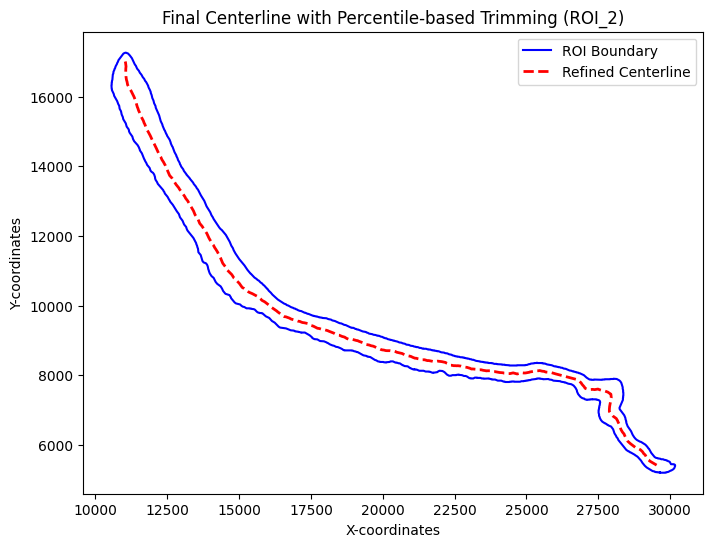

In [4]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, LineString, MultiLineString, Point
from shapely.ops import unary_union
from scipy.spatial import Voronoi

# --------------------------
# 1) Percentile-based Trim
# --------------------------
def trim_ends_by_percentile(centerline, polygon, low_pct=10):
    """
    Trims centerline points whose distance to polygon boundary
    is below the `low_pct` percentile of all distances.
    This automatically adapts to different ROI shapes & sizes.
    """
    if not centerline or not len(centerline.coords):
        return None

    coords = list(centerline.coords)

    # 1. Compute distance to boundary for all points
    #same size as the coords list and first entry here corresponds to the distance of the first point in coords to the boundary, etc. 
    #This allows us to zip the two lists together and then filter based on the distance later on
    dists = [polygon.exterior.distance(Point(pt)) for pt in coords]

    # 2. Determine cutoff using low percentile
    # so if it's 10 it means cutoff is 10th percentile of distances 
    # (idea is that the points with the smallest distances to boundary are the "tails" we noticed that aren't part of the true centerline )
    cutoff = np.percentile(dists, low_pct)

    # 3. Keep only points with distance >= cutoff
    new_coords = [pt for pt, dist in zip(coords, dists) if dist >= cutoff]

    # 4. Rebuild centerline
    if len(new_coords) < 2:
        return None
    return LineString(new_coords)

# --------------------------
# 2) Your Existing Voronoi + Graph Steps
# --------------------------

# For example, choose an ROI to process
roi_name = "ROI_2"
roi_polygon = roi_polygons[roi_name]

# Extract boundary points
boundary_coords = np.array(roi_polygon.exterior.coords)

# Compute Voronoi
vor = Voronoi(boundary_coords)

# Filter Voronoi edges inside the polygon
valid_lines = []
for vpair in vor.ridge_vertices:
    if -1 in vpair:  
        continue
    p1, p2 = vor.vertices[vpair[0]], vor.vertices[vpair[1]]
    line = LineString([p1, p2])
    if roi_polygon.contains(line):
        valid_lines.append(line)

# Merge edges into a single geometry
medial_axis = unary_union(valid_lines)

# Convert to graph
def medial_axis_to_graph(medial_axis):
    G = nx.Graph()
    if isinstance(medial_axis, MultiLineString):
        for line in medial_axis.geoms:
            coords = list(line.coords)
            for i in range(len(coords) - 1):
                #the weight is the distance between the two points
                seg_length = Point(coords[i]).distance(Point(coords[i+1]))
                G.add_edge(coords[i], coords[i+1], weight=seg_length)
    elif isinstance(medial_axis, LineString):
        coords = list(medial_axis.coords)
        for i in range(len(coords) - 1):
            seg_length = Point(coords[i]).distance(Point(coords[i+1]))
            G.add_edge(coords[i], coords[i+1], weight=seg_length)
    return G

G = medial_axis_to_graph(medial_axis)

# Largest connected component
largest_cc = max(nx.connected_components(G), key=len)
G_largest = G.subgraph(largest_cc).copy()

# Find the longest path among terminal nodes
def find_longest_path(G_largest):
    #iterating through all nodes and keeping the ones with degree 1 (terminal nodes)
    print("finding terminal nodes")
    terminal_nodes = [n for n in G_largest.nodes if G_largest.degree[n] == 1]
    #print number of terminal nodes
    print(f"number of terminal nodes: {len(terminal_nodes)}")
    if len(terminal_nodes) < 2:
        return None

    max_length = 0
    best_pair = None
    #double loop tof find distance between each pair of terminal nodes
    #two terminal nodes that are furthest apart should represent the centerline
    print("finding longest path")
    for i in range(len(terminal_nodes)):
        for j in range(i+1, len(terminal_nodes)):
            try:
                path_length = nx.shortest_path_length(
                    G_largest, terminal_nodes[i], terminal_nodes[j], weight="weight"
                )
                if path_length > max_length:
                    max_length = path_length
                    #update best pair to this one with the longest distance
                    best_pair = (terminal_nodes[i], terminal_nodes[j])
            except nx.NetworkXNoPath:
                pass

    if not best_pair:
        return None
    #returns the longest path between the two terminal nodes
    return nx.shortest_path(G_largest, source=best_pair[0], target=best_pair[1], weight="weight")

longest_path = find_longest_path(G_largest)
if longest_path:
    centerline = LineString(longest_path)
else:
    centerline = None

# --------------------------
# 3) Apply Percentile-based Trim
# --------------------------
#centerline is longest path but may have tails--->trim the line to get the true centerline
if centerline:
    # e.g., low_pct=10 means removing points in the lower 10% boundary distance
    centerline = trim_ends_by_percentile(centerline, roi_polygon, low_pct=10)

# --------------------------
# 4) Visualization
# --------------------------
if centerline and len(centerline.coords) > 1:
    print(f"[{roi_name}] Centerline Length (after percentile trim):", centerline.length)

fig, ax = plt.subplots(figsize=(8, 6))
x, y = roi_polygon.exterior.xy
ax.plot(x, y, linestyle="-", color="blue", label="ROI Boundary")

if centerline and len(centerline.coords) > 1:
    cx, cy = centerline.xy
    ax.plot(cx, cy, linestyle="--", color="red", linewidth=2, label="Refined Centerline")

plt.xlabel("X-coordinates")
plt.ylabel("Y-coordinates")
plt.title(f"Final Centerline with Percentile-based Trimming ({roi_name})")
plt.legend()
plt.show()
